<a href="https://colab.research.google.com/github/fauxneticien/lnl-examples/blob/main/02_mwe_extras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note**: Use Colab to view this notebook! Some text involving right-angle brackets such as '&lt;pad&gt;' do not display properly on the GitHub ipynb viewer.

# Using PyTorch Lightning and Lhotse for speech processing research

<p align="center"><img width="500" src="https://user-images.githubusercontent.com/9938298/244146091-1e3cf317-910a-4fcf-a0e2-6e755a4935c0.png"></p>

In the first minimal working example (MWE), located in `notebooks/01_mwe.ipynb` or on [Colab](https://colab.research.google.com/drive/13VzQYEUJGcbQEU6L48jsNU3r46ASwGwp), we covered an absolute barebones example of how to get [PyTorch Lightning](https://github.com/Lightning-AI/lightning) and [Lhotse](https://github.com/lhotse-speech/lhotse) up and running.
In this tutorial, we'll build on the MWE, but add on some extras (e.g. validation step, logging, progress bars, etc.).
As before, by the end of this tutorial you'll understand the reasoning behind the contents in the script `02_mwe-extras.py`.

## Motivations

The table below lists some statistics reported in recent papers working with wav2vec 2.0 models, which illustrates just how compute and time intensive training speech models can be.

To make the most of whatever hardware we have access to, we'll want to use methods like dynamic batch sizing (to reduce padding), gradient accumulation (to increase effective batch sizes), and/or mixed precision (to reduce the overall memory footprint).
Luckily, we can let PyTorch Lightning and Lhotse handle much of the heavy lifting that's involved (if we configure them correctly!)

Config (Model size) | Source | Setup         | Total Steps | Total time (Time per 100k steps) |
-------|-------|---------------|-------|-----------------|
Pre-training from scratch (Base, 95m) | [Baevski et al. 2022](https://arxiv.org/pdf/2212.07525.pdf)    | 32xA100 40GB   | 400k  | 57.3h (14.33h)
Pre-training from scratch (Base, 95m) |[Parcollet et al. 2023](https://hal.science/hal-04116371v1/document)  | 4xA100 80GB   | 200k  | 670h (335h = 14 days)
Continued pre-training (Large, 300m) | [Nowakowski et al. 2023](https://arxiv.org/pdf/2301.07295.pdf) | 4x1080Ti 11GB | 100k  | 5 weeks

Perhaps counter intuitively, we'll dive right into setting up Lightning and Lhotse for multi-GPU training before covering seemingly simpler aspects like logging and progress bars, but how we configure these simpler things will make more sense given an understanding of the (mutli-GPU) setup.

## Setup

### Install dependencies

As before, we'll assume the latest versions of `torch(audio)`, `lightning`, and `lhotse` as of early June 2023.

In [1]:
%%capture

!pip install --quiet torch==2.0.1 torchaudio==2.0.2 lightning==2.0.2 lhotse==1.14.0 gdown jiwer

### Download and load Mini LibriSpeech

In [2]:
from lhotse import CutSet
from lhotse.recipes import download_librispeech, prepare_librispeech

download_librispeech(dataset_parts="mini_librispeech")
libri = prepare_librispeech(corpus_dir="LibriSpeech", output_dir="data/")

cuts_train = CutSet.from_manifests(**libri["train-clean-5"])
cuts_valid = CutSet.from_manifests(**libri["dev-clean-2"])

Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1519 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1089 [00:00<?, ?it/s]

## Multi-GPU training with Lhotse and Lightning

### The wrong way

We'll assume familiarity with most of the code below, given what was covered in the first tutorial. In fact, there might not be anything seemginly out of place. But if you examine what is printed out you'll see the following:

```
device_rank=0; batch_idx=0; cuts_in_batch='1898-145715-0044-1384, 5789-70653-0025-1231, 1898-145715-0030-1370, 460-172359-0021-747, 7367-86737-0049-656, 332-128985-0035-73, 4640-19188-0036-320, 1088-134315-0046-517, 8629-261139-0067-597, 3526-176653-0050-1010'
device_rank=1; batch_idx=0; cuts_in_batch='1898-145715-0044-1384, 5789-70653-0025-1231, 1898-145715-0030-1370, 460-172359-0021-747, 7367-86737-0049-656, 332-128985-0035-73, 4640-19188-0036-320, 1088-134315-0046-517, 8629-261139-0067-597, 3526-176653-0050-1010'
```

Notice that both devices (e.g. GPUs, but CPUs as configured for this example) are getting the same set of utterances every batch.

In [3]:
import torch
import lightning.pytorch as pl

from lhotse.dataset.sampling import BucketingSampler

from torch.utils.data import DataLoader
from torch.distributed import get_rank

class MinimalASRDataset(torch.utils.data.Dataset):
    def __getitem__(self, cuts) -> dict:
        cuts = cuts.sort_by_duration()
        return cuts

class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(2, 2)

    def training_step(self, batch, batch_idx):

        device_rank=get_rank()
        cuts_in_batch = ", ".join([ c.id for c in batch ])
        print(f"{device_rank=}; {batch_idx=}; {cuts_in_batch=}")

        return None

    def configure_optimizers(self):
        # required by Trainer
        return torch.optim.Adam(self.parameters())

pl.seed_everything(42)

print(f"\nInitializing dataloader here\n")

train_loader = DataLoader(
    MinimalASRDataset(),
    sampler=BucketingSampler(cuts_train, max_duration=100, shuffle=True, drop_last=True, seed=42),
    batch_size=None,
    num_workers=1
)

trainer = pl.Trainer(
    accelerator="cpu",
    devices=2,
    max_steps=5,
    use_distributed_sampler=False,
    # Disable for demo
    enable_checkpointing=False,
    enable_model_summary=False,
    enable_progress_bar=False,
    logger=False,
)

trainer.fit(Model(), train_dataloaders=train_loader)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42



Initializing dataloader here



INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: [rank: 1] Global seed set to 42
INFO: [rank: 0] Global seed set to 42
INFO:lightning.fabric.utilities.seed:[rank: 1] Global seed set to 42
INFO:lightning.fabric.utilities.seed:[rank: 0] Global seed set to 42
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO: Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_R

device_rank=0; batch_idx=0; cuts_in_batch='1898-145715-0044-644, 5789-70653-0025-25, 1898-145715-0030-630, 460-172359-0021-944, 7367-86737-0049-127, 332-128985-0035-1447, 4640-19188-0036-1162, 1088-134315-0046-321, 8629-261139-0067-1090, 3526-176653-0050-426'


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


device_rank=0; batch_idx=1; cuts_in_batch='163-122947-0040-818, 226-122538-0008-1333, 4640-19188-0016-1142, 1088-134315-0057-332, 163-122947-0073-851, 163-122947-0077-855, 3242-8112-0016-1223'device_rank=1; batch_idx=0; cuts_in_batch='1898-145715-0044-644, 5789-70653-0025-25, 1898-145715-0030-630, 460-172359-0021-944, 7367-86737-0049-127, 332-128985-0035-1447, 4640-19188-0036-1162, 1088-134315-0046-321, 8629-261139-0067-1090, 3526-176653-0050-426'
device_rank=0; batch_idx=2; cuts_in_batch='332-128985-0038-1450, 1088-134315-0016-291, 460-172359-0025-948, 4680-16042-0020-758, 163-122947-0070-848, 460-172359-0033-956, 1867-154075-0042-919, 19-198-0002-532'

device_rank=0; batch_idx=3; cuts_in_batch='7367-86737-0078-156, 669-129074-0029-597, 460-172359-0038-961, 226-122538-0009-1334, 4680-16042-0009-747, 2136-5147-0017-214'device_rank=1; batch_idx=1; cuts_in_batch='163-122947-0040-818, 226-122538-0008-1333, 4640-19188-0016-1142, 1088-134315-0057-332, 163-122947-0073-851, 163-122947-0077-85

INFO: `Trainer.fit` stopped: `max_steps=5` reached.


INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=5` reached.


device_rank=1; batch_idx=4; cuts_in_batch='332-128985-0085-1497, 7367-86737-0092-170, 332-128985-0079-1491, 163-122947-0034-812, 5789-70653-0016-16, 2136-5147-0040-237, 1970-28415-0029-1196'


It looks like both processes are inadvertently being fed data from the same dataloader/sampler, which we can reproduce as:

In [4]:
train_loader_rank0 = DataLoader(
    MinimalASRDataset(),
    sampler=BucketingSampler(cuts_train, max_duration=100, shuffle=True, drop_last=True, seed=42),
    batch_size=None,
    num_workers=1
)

train_loader_rank1 = DataLoader(
    MinimalASRDataset(),
    sampler=BucketingSampler(cuts_train, max_duration=100, shuffle=True, drop_last=True, seed=42),
    batch_size=None,
    num_workers=1
)

In [5]:
# Cut IDs in first batch from first data loader
", ".join([ c.id for c in next(iter(train_loader_rank0)) ])

'1898-145715-0044-644, 5789-70653-0025-25, 1898-145715-0030-630, 460-172359-0021-944, 7367-86737-0049-127, 332-128985-0035-1447, 4640-19188-0036-1162, 1088-134315-0046-321, 8629-261139-0067-1090, 3526-176653-0050-426'

In [6]:
# Cut IDs in first batch from second data loader
", ".join([ c.id for c in next(iter(train_loader_rank1)) ])

'1898-145715-0044-644, 5789-70653-0025-25, 1898-145715-0030-630, 460-172359-0021-944, 7367-86737-0049-127, 332-128985-0035-1447, 4640-19188-0036-1162, 1088-134315-0046-321, 8629-261139-0067-1090, 3526-176653-0050-426'

### The right way

All we need to do to fix this, is initialize `BucketingSampler` with the correct parameters of `world_size` (how many total devices?) and `rank` (which device is this loader/sampler for?)

In [7]:
train_loader_rank0 = DataLoader(
    MinimalASRDataset(),
    sampler=BucketingSampler(cuts_train, max_duration=100, shuffle=True, drop_last=True, seed=42, world_size=2, rank=0),
    batch_size=None,
    num_workers=1
)

train_loader_rank1 = DataLoader(
    MinimalASRDataset(),
    sampler=BucketingSampler(cuts_train, max_duration=100, shuffle=True, drop_last=True, seed=42, world_size=2, rank=1),
    batch_size=None,
    num_workers=1
)

Notice below that the Cut IDs are now different

In [8]:
# Cut IDs in first batch from first data loader
", ".join([ c.id for c in next(iter(train_loader_rank0)) ])

'1898-145715-0044-644, 5789-70653-0025-25, 1898-145715-0030-630, 460-172359-0021-944, 7367-86737-0049-127, 332-128985-0035-1447, 4640-19188-0036-1162, 1088-134315-0046-321, 8629-261139-0067-1090, 3526-176653-0050-426'

In [9]:
# Cut IDs in first batch from second data loader
", ".join([ c.id for c in next(iter(train_loader_rank1)) ])

'3526-176653-0046-422, 1970-28415-0002-1169, 3947-13262-0045-1405, 332-128985-0031-1443, 6272-70171-0028-516, 8629-261139-0000-1023, 7367-86737-0098-176, 2136-5147-0037-234, 3242-8112-0033-1240, 1737-146161-0007-1508'

`BucketingSampler` can automatically infer the correct `world_size` and `rank` if it is instantiated in the right context. So all we need to do is make sure the dataloaders/samplers are initiliazed **after** Lightning has initialized the distributed processes (as shown below in the logs).

```
INFO: [rank: 0] Global seed set to 42
INFO:lightning.fabric.utilities.seed:[rank: 0] Global seed set to 42
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO: [rank: 1] Global seed set to 42
INFO:lightning.fabric.utilities.seed:[rank: 1] Global seed set to 42
INFO:lightning.fabric.utilities.distributed: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO: Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
```

All we need to do to make sure the orchestration of things happen in the right way is to provide the dataloader inside a PyTorch Lightning DataModule. In that way, `DataLoader()` and `BucketingSampler()` are only called once the distributed processes have been initialized (and thus `world_size` and `rank` are set properly).

In [10]:
class LibrisDataModule(pl.LightningDataModule):
    def train_dataloader(self):

        print(f"\nInitializing dataloader for device {get_rank()}\n")

        return DataLoader(
            MinimalASRDataset(),
            sampler=BucketingSampler(cuts_train, max_duration=100, shuffle=True, drop_last=True),
            batch_size=None,
            num_workers=2
        )

pl.seed_everything(42)

trainer.fit(Model(), LibrisDataModule())

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: [rank: 0] Global seed set to 42
INFO:lightning.fabric.utilities.seed:[rank: 0] Global seed set to 42
INFO: [rank: 1] Global seed set to 42
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO:lightning.fabric.utilities.seed:[rank: 1] Global seed set to 42
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
INFO: Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO:lightning.fabric.utilities.distributed:Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

INFO:lightning.pytorch.utilities.rank_zero:------------------------------------------


Initializing dataloader for device 0

Initializing dataloader for device 1


device_rank=0; batch_idx=0; cuts_in_batch='7367-86737-0078-156, 669-129074-0029-597, 460-172359-0038-961, 226-122538-0009-1334, 4680-16042-0009-747, 2136-5147-0017-214'


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


device_rank=1; batch_idx=0; cuts_in_batch='3664-178355-0002-240, 3242-8112-0034-1241, 6848-252323-0005-42, 6272-70171-0001-489, 7367-86737-0058-136, 7367-86737-0022-100'device_rank=0; batch_idx=1; cuts_in_batch='3947-13262-0049-1409, 226-122538-0004-1329, 460-172359-0086-1009, 332-128985-0028-1440, 7367-86737-0064-142, 332-128985-0041-1453'

device_rank=1; batch_idx=1; cuts_in_batch='3664-178355-0006-244, 1898-145715-0036-636, 7859-102519-0038-469, 1970-28415-0006-1173, 3526-176653-0033-409, 3526-176653-0011-387'device_rank=0; batch_idx=2; cuts_in_batch='7367-86737-0094-172, 8629-261139-0055-1078, 3664-178355-0014-252, 2136-5147-0002-199, 332-128985-0013-1425, 3242-8112-0012-1219'

device_rank=0; batch_idx=3; cuts_in_batch='163-122947-0040-818, 226-122538-0008-1333, 4640-19188-0016-1142, 1088-134315-0057-332, 163-122947-0073-851, 163-122947-0077-855, 3242-8112-0016-1223'device_rank=1; batch_idx=2; cuts_in_batch='163-122947-0097-875, 1867-154075-0045-922, 332-128985-0076-1488, 163-12294

INFO: `Trainer.fit` stopped: `max_steps=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=5` reached.


#### Summary

One of the benefits of using Lightning, at least in my opinion, is that it offers a way to abstract and organize your code in a (kind of) event-driven programming paradigm ('When this happens, do this'). In this way, we can let Lightning handle a lot of the plumbing (setting up the distributed training, moving data to the right devices, calling `model.eval()` during validation, etc.) and inject our custom code snippets in the right places (via callbacks). So we'll see shortly how almost everything will get organized in terms of various (pairs of) [callbacks](https://lightning.ai/docs/pytorch/latest/api/lightning.pytorch.callbacks.Callback.html#lightning.pytorch.callbacks.Callback):

- `on_train_batch_start`, `on_train_batch_end`
- `on_before_backward`, `on_after_backward`
- `on_before_optimizer_step`
- `on_before_zero_grad`

(As an aside, this is somewhat reminiscent of how jQuery came along and just made it so much easier to get this done without a ton of pure JavaScript/HTML boilerplate and dozens of `document.getElementById()` strewn about everywhere).

## Modular configuration with Lightning Modules

Another benefit of using Lightning Datamodules for data processing along with Lightning Modules for the model is that it can allow for datasets and models to be swappable if they are setup to be configured correctly.

For example, let's have a look at some snippets from `train_mwe.py` below. As before, there's some orchestration about what needs to be set when. The `TokenCollater` needs to be setup before the model is initialized in order to know the number of output classes for the final layer and the feature extractor needs to know how many Mel bins the model is expecting for processing the input wav files.

```python
# Number of output classes defined by:
# len(list(tokenizer.idx2token))
tokenizer = TokenCollater(cuts_train)

class DeepSpeechLightningModule(pl.LightningModule):
    def __init__(self, n_feature, tokenizer):
        super().__init__()

        self.model = torchaudio.models.DeepSpeech(
          n_feature=n_feature,
          # Model needs to know how many label classes to output
          n_class=len(list(tokenizer.idx2token))
        )

class MinimalASRDataset(torch.utils.data.Dataset):
    def __init__(self):
        # Feature extractor needs to know how many FBank bins to use for
        # model input
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=80)))
        self.tokenizer = tokenizer

```

Instead of having to hard-code a global variable, say `N_FEATURE`, at the top, we can set them as attributes of the various modules. Additionally, we can take advantage of some of the orchestration features that Lightning helps with to organize setting/getting various attributes between `__init__()` and what Lightning provides as `setup()`.

In [11]:
import torch
import torchaudio

from lhotse import CutSet, Fbank, FbankConfig
from lhotse.dataset import BucketingSampler, OnTheFlyFeatures
from lhotse.dataset.collation import TokenCollater

class DeepSpeechLightningModule(pl.LightningModule):

    def __init__(self, n_feature=80):
        super().__init__()
        # Set input feature dimension on init so DataModule can use info
        print("\n-------------- Calling DeepSpeechLightningModule __init__() here --------------\n")
        self.n_feature = n_feature

    def setup(self, stage = None):
        print("\n-------------- Calling DeepSpeechLightningModule setup() here --------------\n")
        self.model = torchaudio.models.DeepSpeech(
            # Set in __init__() above
            n_feature=self.n_feature,
            # Set in LibrisDataModule setup()
            n_class=self.trainer.datamodule.tokenizer_n_class
        )

        output_labels = list(self.trainer.datamodule.tokenizer.idx2token)
        pad_token = output_labels.index('<pad>')

        # For details, see loss usage section in notebooks/01_mwe.ipynb
        self.ctc_loss = torch.nn.CTCLoss(blank=pad_token, reduction="sum", zero_infinity=True)

    def configure_optimizers(self):
        # required by Trainer, but not relevant for this test
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1)
        return optimizer

    def training_step(self, batch, batch_idx):
        return None

class LibrisDataModule(pl.LightningDataModule):
    def prepare_data(self,) -> None:
        print("\n-------------- Calling LibrisDataModule prepare_data() here --------------\n")
        # See Note: "Use this to download and prepare data. Downloading and saving data with multiple processes (distributed settings) will result in corrupted data."
        # And Warning: "DO NOT set state to the model (use setup instead) since this is NOT called on every device"
        # https://lightning.ai/docs/pytorch/2.0.2/api/lightning.pytorch.core.hooks.DataHooks.html#lightning.pytorch.core.hooks.DataHooks.prepare_data
        download_librispeech(dataset_parts="mini_librispeech")

    def setup(self, stage = None):
        print("\n-------------- Calling LibrisDataModule setup() here --------------\n")
        libri = prepare_librispeech(corpus_dir="LibriSpeech", output_dir="data/")
        self.cuts_train = CutSet.from_manifests(**libri["train-clean-5"])
        self.cuts_val = CutSet.from_manifests(**libri["dev-clean-2"])

        self.tokenizer = TokenCollater(self.cuts_train)
        # Set number of total unique labels (i.e. output dimensions) to be fetched by model class during setup
        self.tokenizer_n_class = len(list(self.tokenizer.idx2token))

        # Fetch input dimensions model expects to pass to feature extractor
        # We fetch the attribute here instead of in train_dataloader(), after which
        # it no longer exists as self.trainer.model, since it will be wrapped in
        # DistributedDataParallel() by Lightning
        self.model_n_feature = self.trainer.model.n_feature

    def train_dataloader(self):

        return DataLoader(
            MinimalASRDataset(self.model_n_feature, self.tokenizer),
            sampler=BucketingSampler(self.cuts_train, max_duration=300, shuffle=True, drop_last=True),
            batch_size=None,
            num_workers=1
        )

class MinimalASRDataset(torch.utils.data.Dataset):
    def __init__(self, model_n_feature, tokenizer):
        print("\n-------------- Calling MinimalASRDataset __init__() here --------------\n")
        # This __init__() won't be called until train_dataloader() is called
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=model_n_feature)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"inputs_padded": feats, "input_lengths": feat_lens, "labels_padded": tokens, "label_lengths": token_lens}

trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_steps=1,
    use_distributed_sampler=False,
    # Disable for demo
    enable_checkpointing=False,
    enable_model_summary=False,
    enable_progress_bar=False,
    logger=False,
)

trainer.fit(DeepSpeechLightningModule(), LibrisDataModule())

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



-------------- Calling DeepSpeechLightningModule __init__() here --------------


-------------- Calling LibrisDataModule prepare_data() here --------------




-------------- Calling LibrisDataModule setup() here --------------



Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1519 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1089 [00:00<?, ?it/s]


-------------- Calling DeepSpeechLightningModule setup() here --------------


-------------- Calling MinimalASRDataset __init__() here --------------



/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")
INFO: `Trainer.fit` stopped: `max_steps=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


You can see from the output above that the call order is:
1. `DeepSpeechLightningModule.__init__()` (so we set `n_feature` here so `LibrisDataModule` can know how to configure the dataloader)
2. `LibrisDataModule.prepare_data()`
3. `LibrisDataModule.setup()` (setup `TokenCollator` here so we can use it to configure the model)
4. `DeepSpeechLightningModule.setup()` (we can now setup the model since `n_feature` and `n_class` are both now known)
5. `MinimalASRDataset.__init__()` (feature extractor can be setup since it also knows `n_feature` from having `LibrisDataModule` fetch it during setup)
  - Also recall `BucketingSampler()` will be initialized here and thus be able to infer `world_size` and `rank` properly

This way of handling inter-module configuration will help us swap out models and datasets in future, e.g.:

```python
from my_models_collection import ConformerLightningModule
from my_datasets_collection import SwitchboardDataModule

# Swap to another dataset
trainer.fit(DeepSpeechLightningModule(), SwitchboardDataModule())
# Swap to another model
trainer.fit(ConformerLightningModule(), LibrisDataModule())
# Swap to another dataset and model
trainer.fit(ConformerLightningModule(), SwitchboardDataModule())
```

## Adding a validation step

### Setup decoder

Recall from `notebooks/01_mwe.ipynb` that the outputs of the (ideal) DeepSpeech model is a sequence of logits, one for each time step in the input, which expresses a prediction as in the figure below (representing raw probabilities).

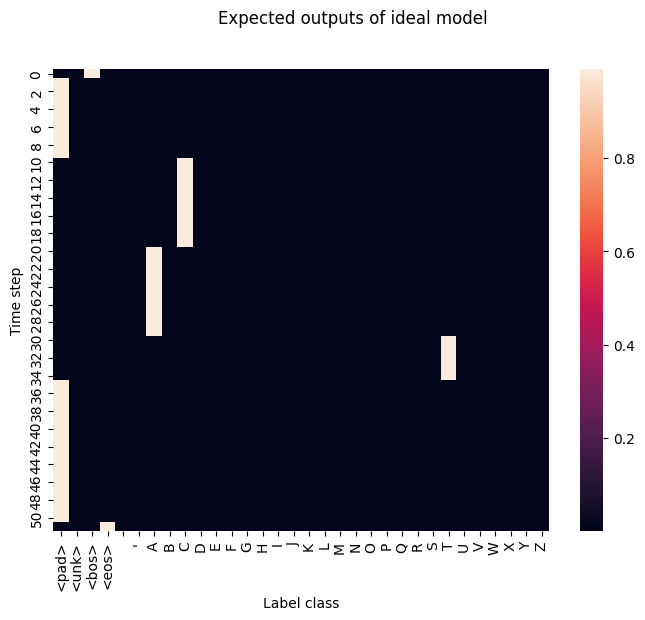

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

labels="<pad>,<unk>,<bos>,<eos>, ,',A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z"

plt.figure(figsize=(8,6))
plt.suptitle("Expected outputs of ideal model")

ideal_outputs = torch.full((52, 32), (1-0.99)/31)           # Distribute remaining prob mass equally across other labels
ideal_outputs[10:20, labels.split(",").index("C")] = 0.99   # Some time steps are 'C'
ideal_outputs[20:30, labels.split(",").index("A")] = 0.99   # Some time steps are 'A'
ideal_outputs[30:35, labels.split(",").index("T")] = 0.99   # Some time steps are 'T'
ideal_outputs[1:10, 0] = 0.99                               # Fill rest with <pad>
ideal_outputs[35:51, 0] = 0.99                              # Fill rest with <pad>
ideal_outputs[0, labels.split(",").index("<bos>")] = 0.99
ideal_outputs[-1, labels.split(",").index("<eos>")] = 0.99

ax = sns.heatmap(
  ideal_outputs,
  xticklabels=labels.split(",")
)
ax.set(xlabel='Label class', ylabel='Time step')

plt.show()

#### Greedy decoder

To evaluate how well this output corresponds to our expected text label (i.e. 'cat'), we need to transform this matrix into a text string. For this tutorial, we'll simply use 'greedy decoding' which is to naïvely take the most probably character at each time step (via `torch.argmax`) then collapse repeated characters (e.g. `CCC -> C`, via `torch.unique_consecutive`):

In [13]:
indices = torch.argmax(ideal_outputs, axis=-1)

indices

tensor([ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 25, 25, 25, 25, 25,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3])

In [14]:
unique_indices = torch.unique_consecutive(indices, dim=-1)

unique_indices

tensor([ 2,  0,  8,  6, 25,  0,  3])

In [15]:
# labels repeated here for convenience
labels="<pad>,<unk>,<bos>,<eos>, ,',A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z"
labels_array = labels.split(",")

# skip special tokens such as <pad>
prediction = "".join([ labels_array[i] for i in unique_indices if "<" not in labels_array[i] ])

prediction

'CAT'

### Evaluate decoded text

Once we have the decoded text, we can use the Word Error Rate (WER) and Character Error Rate (CER) metrics from the `jiwer` package to evaluate the model's output. Note both are `0.0` in this case because there are no errors in the prediction `CAT` (same as correct answer `CAT`).

In [16]:
import jiwer

# The correct answer
reference = 'CAT'

wer = jiwer.wer(reference, prediction)
cer = jiwer.cer(reference, prediction)

print(f"{wer=}, {cer=}")

wer=0.0, cer=0.0


### Decoder configuration in setup sequence

You'll notice that the decoder needs to know the mapping between the output layer indices and the text labels (e.g. `8 -> C`). So the decoder will have to be setup only after the DataModule's `TokenCollator` has been called.

At the same time, we might want to try out different decoders (e.g. beam search), so we won't want to hard-code the decoder into the model. As before, we'll retain modularity by following the Lightning setup template by passing in some swappable object of which there is a `setup()` method that can be called at the right time.

In [17]:
class DeepSpeechLightningModule(pl.LightningModule):

    def __init__(self, val_decoder, n_feature=80):
        super().__init__()
        # Set input feature dimension on init so DataModule can use info
        print("\n-------------- Calling DeepSpeechLightningModule __init__() here --------------\n")
        self.n_feature = n_feature
        self.val_decoder = val_decoder

    def setup(self, stage = None):
        print("\n-------------- Calling DeepSpeechLightningModule setup() here --------------\n")
        self.model = torchaudio.models.DeepSpeech(
            # Set in __init__() above
            n_feature=self.n_feature,
            # Set in LibrisDataModule setup()
            n_class=self.trainer.datamodule.tokenizer_n_class
        )

        output_labels = list(self.trainer.datamodule.tokenizer.idx2token)
        pad_token = output_labels.index('<pad>')

        # For details, see loss usage section in notebooks/01_mwe.ipynb
        self.ctc_loss = torch.nn.CTCLoss(blank=pad_token, reduction="sum", zero_infinity=True)

        self.val_decoder.setup(output_labels, pad_token)

    def configure_optimizers(self):
        # required by Trainer, but not relevant for this test
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1)
        return optimizer

    def training_step(self, batch, batch_idx):
        return None

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def setup(self, output_labels, pad_token=0):
        print("\n-------------- Calling GreedyCTCDecoder setup() here --------------\n")
        self.output_labels = output_labels
        self.pad_token = pad_token

    def forward(self, log_probs: torch.Tensor):
        """
        Input: Log-probs matrix of shape (B, T, C) Batch x Time x Class
        Output: List of text of B items, ["THE CAT", "HELLO", ..., "THIS IS AN EXAMPLE"]
        """
        indices = torch.argmax(log_probs, dim=-1)

        predictions = []

        for p in list(indices):
            unique_indices = torch.unique_consecutive(p, dim=-1)
            prediction = "".join([ self.output_labels[t] for t in unique_indices if "<" not in self.output_labels[t] ])
            predictions.append(prediction)

        return predictions

trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_steps=1,
    use_distributed_sampler=False,
    # Disable for demo
    enable_checkpointing=False,
    enable_model_summary=False,
    enable_progress_bar=False,
    logger=False,
)

trainer.fit(
  DeepSpeechLightningModule(val_decoder=GreedyCTCDecoder()),
  LibrisDataModule()
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



-------------- Calling DeepSpeechLightningModule __init__() here --------------


-------------- Calling LibrisDataModule prepare_data() here --------------




-------------- Calling LibrisDataModule setup() here --------------



Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1519 [00:00<?, ?it/s]

Distributing tasks: 0it [00:00, ?it/s]

Processing:   0%|          | 0/1089 [00:00<?, ?it/s]


-------------- Calling DeepSpeechLightningModule setup() here --------------


-------------- Calling GreedyCTCDecoder setup() here --------------


-------------- Calling MinimalASRDataset __init__() here --------------



INFO: `Trainer.fit` stopped: `max_steps=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


### Add `validation_step` and `on_validation_epoch_end`

Once the decoder is in place, we can add the `validation_step` and `on_validation_epoch_end` hooks which will be called, respectively, to process each batch during validation and then (optionally) to process the entire validation set at the end of the validation epoch (e.g. to aggregate across batches).

#### Notes
- Since `validation_step` is basically the same as a training step (except with say `model.eval()`, which Lightning takes care of for us), we'll also abstract the common steps into a `_step` method.
- Note that Lightning leaves it up to you to store and aggregate your validation predictions yourself. We do this by initializing to empty arrays in `__init__()`: `self.val_losses` and `self.val_ref_pred_pairs` to store validation losses and reference/prediction tuples after each batch.
  - We aggregate across them after we've gone through all batches, i.e. in `on_validation_epoch_end` and also clear them, i.e. `self.val_losses.clear()` after we're done with them for a given validation round.
- As mentioned above, some of the configuration options are only necessary because we're aiming to be compatible for both single- and multi-device setups. For example, `sync_dist=True` in `self.log()` synchronizes what's being logged in a distributed setup.

In [18]:
import pandas as pd

class DeepSpeechLightningModule(pl.LightningModule):

    def __init__(self, val_decoder, n_feature=80):
        super().__init__()
        self.n_feature = n_feature
        self.val_decoder = val_decoder

        # Create empty arrays to aggregate across validation batches
        self.val_losses = []
        self.val_ref_pred_pairs = []

    ################## OMITTED A BUNCH OF STUFF HERE FOR BREVITY ##################

    def _step(self, batch, batch_idx, step_type):
        # For details, see loss usage section in notebooks/01_mwe.ipynb
        log_probs   = self.model(batch['inputs_padded'])
        loss = self.ctc_loss(log_probs.transpose(0, 1), batch["labels_padded"], batch["input_lengths"], batch["label_lengths"])

        # For multi-GPU training, normalize the loss based on the sum of batch_size across all GPUs
        batch_size = batch['inputs_padded'].size(0)
        # Get batch sizes from all GPUs
        batch_sizes = self.all_gather(batch_size)
        # Normalize by world size / batch size
        loss *= batch_sizes.size(0) / batch_sizes.sum()

        self.log(f"{step_type}/loss", loss.item(), sync_dist=True, prog_bar=True)

        return loss, log_probs

    def training_step(self, batch, batch_idx):
        loss, _ = self._step(batch, batch_idx, "train")
        return loss

    def validation_step(self, batch, batch_idx):

        loss, log_probs = self._step(batch, batch_idx, "val")

        # Retrieve text of gold labels given the numeric representations
        refs  = self.trainer.datamodule.tokenizer.inverse(batch["labels_padded"], batch["label_lengths"])
        # Decode model predictions into text
        preds = self.val_decoder(log_probs)

        self.val_losses.append(loss.item())
        self.val_ref_pred_pairs += list(zip(refs, preds))

        return loss

    def on_validation_epoch_end(self, *_):
        # Use self.all_gather to gather across devices in multi-device setup
        val_loss_mean = torch.mean(torch.tensor(self.all_gather(self.val_losses)))

        refs_preds_df = pd.DataFrame(
            self.all_gather(self.val_ref_pred_pairs),
            columns=["Reference", "Prediction"]
        )

        # Free memory
        self.val_losses.clear()
        self.val_ref_pred_pairs.clear()

        # Only log the gathered metrics on main process
        if self.trainer.is_global_zero:
            wer = jiwer.wer(refs_preds_df['Reference'].to_list(), refs_preds_df['Prediction'].to_list())
            cer = jiwer.cer(refs_preds_df['Reference'].to_list(), refs_preds_df['Prediction'].to_list())

            self.log("val/loss", val_loss_mean, rank_zero_only=True, sync_dist=True)
            self.log("val/wer", wer, rank_zero_only=True, sync_dist=True)
            self.log("val/cer", cer, rank_zero_only=True, sync_dist=True)

            # Only print if training has already started (i.e. not during sanity check)
            if self.trainer.global_step > 0:
                print("\n------------------")
                print(refs_preds_df)
                print(f"{trainer.global_step=} {wer=:.2f}, {cer=:.2f}")
                print("------------------\n")


In addition to logging the metrics (e.g. `val/wer` and `val/cer`), we also print the metrics and a pandas data frame of the references/predictions to the console so we can spot check how the training is going (sample print out below):

```
------------------
                                             Reference                                         Prediction
0    TWO OR THREE MILES FARTHER ON IS THE MAIN STRO...  TWOETHREE MILS FON HERON IS THE MAN STRONG O O...
1    GIVE ME MY HORSE AND ARMS AND WAIT FOR ME HERE...  DIVE ME MY GHORSEN ARMSE AND WA FORM ME HER I ...
2    THE LOFTY ICY SHASTA TOWERING HIGH ABOVE ALL S...  THE LOF THE  SHE SHASDTAT TOWRING HI HA BOVALL...
3    DANTE BECAUSE VIRGILIUS HAS DEPARTED DO NOT WE...  DONTEY THE COUS BCUELIAS HIS O PADED DO NONC W...
4    EVIL TO HIM THAT THINKS OTHERWISE SAID MISTER ...  E ULTING U MET TEXSETERWERNTSSI ISSMERITM WOR ...
..                                                 ...                                                ...
850  OF COURSE I KNOW BARTLEY SHE SAID AT LAST THAT...  OF COURSE II NO BAR LEY SHE SANA LSET THA OFTE...
851  HAD GWYNPLAINE WHEN A CHILD BEEN SO WORTHY OF ...  HED QANPLANT WHEN A HAL BIN SO WERET THE ATA T...
852  OTHERS HAD DIED BEFORE DURING THE TWENTIES AND...  ISZUCAD DLI EFOR GRG AN T WENDUSE AN TUIS HURI...
853  SOME APPREHENSION KEEPS YOU MARVELLING BUT THE...  SONE APPREHUNCION KEEESY MURBILEING LUAT THE S...
854  HERE WOOD PIGEON SAID MOTHER MAGPIE YOU MUST P...  EER WIK PAD OUNS AID MOTHER BAK PIY YOU MU'S L...
[855 rows x 2 columns]
trainer.global_step=10000 wer=0.87, cer=0.39
------------------

```

## Add logging

So far, since we've been using the `logger=False` flag in the trainer, the metrics logged using `self.log()` won't actually get stored anywhere. Adding logging is straightfoward as given by the various examples in [the documentation](https://lightning.ai/docs/pytorch/2.0.2/extensions/logging.html). All you really need to decide is *where* things should get logged based on your personal/project preferences (e.g. Tensoboard, Weights & Biases, etc.)

```python
trainer = pl.Trainer(
    # Other options ...
    logger=False
)
```

For the minimal working examples, we'll use a simple CSVLogger so you won't need any other accounts setup to run the scripts.

```python
from lightning.pytorch.loggers import CSVLogger

csv_logger = CSVLogger("logs_lnl-examples", name="mwe-extras")

trainer = pl.Trainer(
    # Other options ...
    logger=csv_logger
)
```

Personally, I use Weights & Biases, which can be configured as:

```python
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project='lnl-examples', name="mwe-extras")

trainer = pl.Trainer(
    # Other options ...
    logger=wandb_logger
)
```

## Watch your step!

It must be said that as of early June 2023, the definition of what a 'step' means in Lightning is not globally unambiguous (see open issue [here](https://github.com/Lightning-AI/lightning/issues/13752)), so let's clarify what a step means in different contexts for Lightning 2.0.2 (this may/likely change, so beware!)

Let's create a dummy model and log a bunch of things then analyze the behaviour of various parameters.

In [19]:
%%capture
import torch
import lightning.pytorch as pl

from lightning.pytorch.demos.boring_classes import BoringDataModule
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor

class DummyModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(2, 2)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, pct_start=0.5, total_steps=10, anneal_strategy='linear')

        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step", 'frequency': 1 }
        }

    def training_step(self, batch, batch_idx):
        self.log("train/step", batch_idx)
        return None

    def validation_step(self, batch, batch_idx):
        return None

    def on_validation_epoch_end(self, *_):
        self.log("val/loss", float('inf'))
        return None

trainer = pl.Trainer(
    max_steps=10,
    accumulate_grad_batches=2,
    val_check_interval=10,
    callbacks=[ LearningRateMonitor(logging_interval='step') ],
    log_every_n_steps=1,
    logger=CSVLogger("logs_lnl-examples", name="mwe-extras_watch-step"),
    accelerator="cpu",
    devices=1,
    # Disable for demo
    enable_checkpointing=False,
    enable_model_summary=False,
    enable_progress_bar=False
)

trainer.fit(DummyModel(), BoringDataModule())

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer.fit` stopped: `max_steps=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.


We can see from the CSV log of the run below that:
- `max_steps` correspond to max *updates* (Note: `step=10` stops the trainer after 10 iterations, i..e `0-9`)
  - Note that the learning rate peaks at `1.0` on `step=4`, so the `{"interval": "step", 'frequency': 1`} in the scheduler configuration follows this 'max_steps/updates' step
- `train/step` correspond to number of training steps, which in this case is 20 steps (`0-19`) because we have set `accumulate_grad_batches=2`
  - Thus the validation runs **twice** (note the two `inf` cells in `val/loss`) because `val_check_interval=10` and its count is based on number of steps (of batches seen by the model).
    - To configure validation to run only every n *updates*, it needs to be set to `max_steps * accumulate_grad_batches`

In [20]:
import pandas as pd

metrics_df = pd.read_csv("logs_lnl-examples/mwe-extras_watch-step/version_0/metrics.csv")

print(metrics_df.fillna(""))


    lr-AdamW  step train/step epoch val/loss
0       0.04     0                          
1       0.04     0                          
2                0        1.0   0.0         
3       0.28     1                          
4       0.28     1                          
5                1        3.0   0.0         
6       0.52     2                          
7       0.52     2                          
8                2        5.0   0.0         
9       0.76     3                          
10      0.76     3                          
11               3        7.0   0.0         
12       1.0     4                          
13       1.0     4                          
14               4        9.0   0.0         
15               4              0.0      inf
16  0.800001     5                          
17  0.800001     5                          
18               5       11.0   0.0         
19  0.600002     6                          
20  0.600002     6                          
21        

## Ready-to-run: `train_mwe-extras.py`

Everything we have covered in this section above should be enough to understand and run the [`train_mwe-extras.py`](https://github.com/fauxneticien/lnl-examples/blob/main/train_mwe.py) script.